姿态估计在许多计算机视觉应用中非常重要：机器人导航、增强现实等等。该过程基于寻找真实环境中的点与其二维图像投影之间的对应关系。这通常是一个困难的步骤，因此通常使用合成或基准标记来使其变得更容易。

这些标记的主要好处是单个标记提供足够的对应关系（其四个角）来获取相机姿势。此外，内部二进制编码使它们特别稳健，从而可以应用错误检测和纠正技术。

## markers and directionaries

ArUco 标记是一种合成方形标记，由宽黑色边框和确定其标识符 (id) 的内部二进制矩阵组成。黑色边框有利于其在图像中的快速检测，而二进制编码允许其识别以及错误检测和校正技术的应用。标记的大小决定了内部矩阵的大小。例如，4x4 的标记大小由 16 位组成

标记字典是特定应用程序中考虑的标记集。它只是每个标记的二进制编码列表
标记字典是特定应用程序中考虑的标记集。它只是每个标记的二进制编码列表。
字典的主要属性是字典大小和标记大小。
字典大小是组成字典的标记的数量。
标记大小是这些标记的大小（位数）。

aruco 模块包括一些预定义的字典，涵盖一系列不同的字典大小和标记大小。
人们可能会认为标记id是二进制编码转换为十进制基数得到的数字。然而，这是不可能的，因为对于高标记大小来说，位数太高并且管理如此巨大的数字是不切实际的。相反，标记 id 只是其所属字典中的标记索引。例如，字典中的前 5 个标记的 ID 为：0、1、2、3 和 4。
“选择字典”部分提供了有关字典的更多信息。

## marker creation

在检测之前，需要打印标记以便放置在环境中。可以使用generateImageMarker()函数生成标记图像。

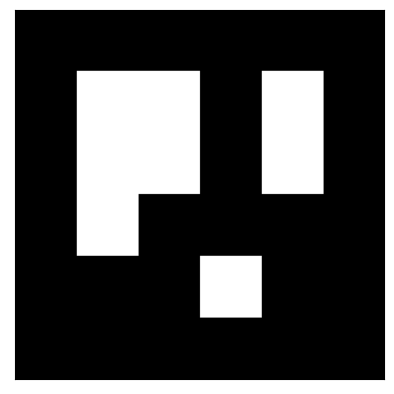

In [5]:
import cv2 as cv
import cv2.aruco as aruco
import numpy as np
from matplotlib import pyplot as plt

image_size = 1000
marker_size = 1000

markerImage = np.zeros((image_size,image_size), np.uint8)
#markerImage = cv.cvtColor(blank_markerImage,cv.COLOR_BGR2GRAY)
dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_250)
generator = aruco.generateImageMarker(dictionary,23,marker_size,markerImage,1)
# markerImage[image_size//2 - marker_size//2:image_size//2 + marker_size//2,
#       image_size//2 - marker_size//2:image_size//2 + marker_size//2] = generator


cv.imwrite("marker4X4.png",generator)
# cv.imshow("markerImage",markerImage)
# plt.imshow(markerImage)
plt.xticks([]),plt.yticks([])
plt.imshow(cv.cvtColor(markerImage,cv.COLOR_BGR2RGB))
plt.show()




## Marker detection
给定包含 ArUco 标记的图像，检测过程必须返回检测到的标记的列表。每个检测到的标记包括：
1其四个角在图像中的位置（按原始顺序）。
2标记的 ID。

1.检测候选标记。在此步骤中，分析图像以找到作为标记候选的正方形形状。它首先使用自适应阈值来分割标记，然后从阈值图像中提取轮廓，并丢弃那些不凸或不近似正方形的轮廓。还应用了一些额外的过滤（删除太小或太大的轮廓，删除彼此太接近的轮廓等）。

2 候选检测后，需要通过分析其内部编码来确定它们是否真正是标记。此步骤首先提取每个标记的标记位。为此，首先应用透视变换以获得规范形式的标记。然后，使用 Otsu 对规范图像进行阈值处理以分离白色和黑色位。根据标记大小和边框大小将图像划分为不同的单元格。然后计算每个单元中黑色或白色像素的数量，以确定它是白色位还是黑色位。最后，分析这些位以确定标记是否属于特定字典。必要时采用纠错技术。

在aruco模块中，检测是在DetectMarkers()函数中进行的。此函数是模块中最重要的函数，因为所有其余功能都基于由 detectorMarkers() 返回的检测到的标记。

(array([[[359., 310.],
        [404., 310.],
        [409., 351.],
        [362., 350.]]], dtype=float32), array([[[427., 255.],
        [469., 256.],
        [477., 289.],
        [434., 288.]]], dtype=float32), array([[[233., 273.],
        [190., 273.],
        [196., 241.],
        [237., 241.]]], dtype=float32), array([[[298., 185.],
        [334., 186.],
        [335., 212.],
        [297., 211.]]], dtype=float32), array([[[425., 163.],
        [430., 186.],
        [394., 186.],
        [390., 162.]]], dtype=float32), array([[[195., 155.],
        [230., 155.],
        [227., 178.],
        [190., 178.]]], dtype=float32))
[[ 40]
 [ 98]
 [ 62]
 [ 23]
 [124]
 [203]]
(array([[[390., 340.],
        [402., 339.],
        [404., 345.],
        [391., 346.]]], dtype=float32), array([[[378., 329.],
        [384., 330.],
        [385., 346.],
        [378., 345.]]], dtype=float32), array([[[382., 325.],
        [400., 324.],
        [402., 330.],
        [384., 330.]]], dtype=float32), a

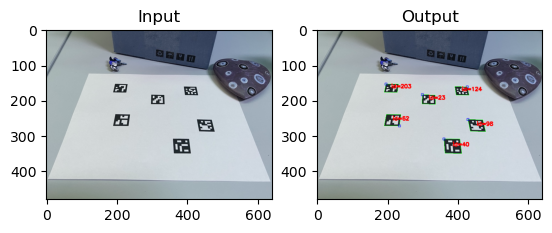

In [16]:
import cv2 as cv
import cv2.aruco as aruco
import numpy as np
import matplotlib.pyplot as plt

markerIds = []
markerCorners = []
rejectedCandidates = []

inputImage = cv.imread('markers.jpg')
assert inputImage is not None,"file could not be read ,check with os.path.exists()"


# 定义 ArUco 字典和检测器参数
detectorParams = aruco.DetectorParameters()
dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
# 创建 ArUco 检测器
arucoDetector = aruco.ArucoDetector(dictionary,detectorParams)
# 使用检测器检测标记
markerCorners, markerIds, rejectedCandidates= arucoDetector.detectMarkers(inputImage)

print(markerCorners)
print(markerIds)
print(rejectedCandidates)

outputImage = np.copy(inputImage)
# 使用OpenCV绘制检测到的标记
aruco.drawDetectedMarkers(outputImage,markerCorners,markerIds)
cv.imwrite('DetectedMarkers.jpg',outputImage)

plt.subplot(121),plt.imshow(inputImage),plt.title('Input')
plt.subplot(122),plt.imshow(outputImage),plt.title('Output')
plt.show()


In [6]:
import cv2 as cv
import numpy as np
import cv2.aruco as aruco

#自检设备号
device_id = -1
for i in range(5):
    cap = cv.VideoCapture(i)
    if cap.isOpened():
        device_id = i
if device_id == -1:
    print('camera not detect')
    exit(-1)       
#open the Zed camera
cap = cv.VideoCapture(device_id)
if cap.isOpened() == 0:
    exit(-1)

# 定义 ArUco 字典和检测器参数
detectorParams = aruco.DetectorParameters()
dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_250)
# 创建 ArUco 检测器
arucoDetector = aruco.ArucoDetector(dictionary,detectorParams)

# 设置所需的分辨率
desired_width = 4416
desired_height = 1242

# 设置摄像头分辨率
cap.set(3, desired_width)  # 设置宽度
cap.set(4, desired_height)  # 设置高度

while(1):
    markerIds = []
    markerCorners = []
    rejectedCandidates = []
    #捕获一帧视频
    ret,frame = cap.read()

    #检测Aruco标记
    markerCorners, markerIds, rejectedCandidates= arucoDetector.detectMarkers(frame)
    #如果至少检测到一个标记
    if markerIds is not None:
        frame = aruco.drawDetectedMarkers(frame,markerCorners,markerIds)
     
    cv.imshow("detect image",frame)   
    #等待用户按键，按esc退出循环
    key = cv.waitKey(5) & 0xFF
    if key == 27:
        break
    
#释放摄像头并关闭窗口
cap.release()
cv.destroyAllWindows()

[ WARN:0@5420.504] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@5420.504] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
[ WARN:0@5420.508] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video2): can't open camera by index
[ERROR:0@5420.508] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
[ WARN:0@5420.508] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ERROR:0@5420.508] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
[ WARN:0@5420.508] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video4): can't open camera by index
[ERROR:0@5420.509] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


In [1]:
import cv2

# 尝试打开摄像头，逐个查看可用摄像头的索引
for i in range(5):
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"摄像头索引 {i}: 可用")
        cap.release()
    else:
        print(f"摄像头索引 {i}: 不可用")

摄像头索引 0: 不可用
摄像头索引 1: 可用
摄像头索引 2: 不可用
摄像头索引 3: 不可用
摄像头索引 4: 不可用


[ WARN:0@0.007] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@0.008] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
[ WARN:0@0.011] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video2): can't open camera by index
[ERROR:0@0.011] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
[ WARN:0@0.011] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ERROR:0@0.011] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
[ WARN:0@0.011] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video4): can't open camera by index
[ERROR:0@0.011] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


Pose Estimation 